# Import packages, set directories

In [14]:
print('Importing packages...')
import os
import pandas
import time
import numpy as np
from matplotlib import pyplot as plt
import geopandas
import re
from IPython.display import display, HTML

pandas.set_option('display.max_colwidth', -1)

acs5_data_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/acs5/'
#shapefiledir = '/home/idies/workspace/Storage/raddick/Baltimore/shapefiles/'
tiger_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/'

#basedir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/datasets/acs5/'
#census_data_basedir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/datasets/acs5/'

thisdir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/'
datadir = thisdir + 'datasets/'
census_data_dir = datadir + 'acs5/'
figdir = thisdir + 'figures/'

for x in [acs5_data_basedir, thisdir, datadir, figdir]:
    if not(os.path.exists(x)):
        os.makedirs(x)

os.chdir(thisdir)
os.getcwd()
#os.listdir()

Importing packages...


'/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act'

# Read loan data

In [15]:
# read aggregate data
agg_tracts_df = pandas.read_csv(datadir+'loans_by_census_tract_2010_2017.csv', encoding='utf-8', low_memory=False)
#agg_tracts_df = agg_tracts_df[agg_tracts_df['activity_year'] >= 2012]

# parse amounts in dollars into numerics
for thiscol in ['amtLoans1', 'amtLoans100k', 'amtLoans250k', 'amtLoansToSmallest', 'amtLoansTotal']:
    agg_tracts_df.loc[:, thiscol] = pandas.to_numeric(agg_tracts_df[thiscol].apply(lambda x: str(x).replace(',','')[1:]), errors='coerce')

# Add community statistical area names
tract_to_csa_df = pandas.read_csv('census_tract_to_neighborhood.csv', index_col='NAME10')
agg_tracts_df = agg_tracts_df.assign(CSA2010 = agg_tracts_df.join(tract_to_csa_df, how='left', on='census_tract')['CSA2010'])

# Get income group names
agg_tracts_df = agg_tracts_df.assign(income_group = np.nan)
agg_tracts_df.loc[agg_tracts_df['income_group_code'] == 1, 'income_group'] = '< 10% of Median Family Income (MFI)'
agg_tracts_df.loc[agg_tracts_df['income_group_code'] == 2, 'income_group'] = '10% to 20% of MFI'
agg_tracts_df.loc[agg_tracts_df['income_group_code'] == 3, 'income_group'] = '20% to 30% of MFI'
agg_tracts_df.loc[agg_tracts_df['income_group_code'] == 4, 'income_group'] = '30% to 40% of MFI'
agg_tracts_df.loc[agg_tracts_df['income_group_code'] == 5, 'income_group'] = '40% to 50% of MFI'
agg_tracts_df.loc[agg_tracts_df['income_group_code'] == 6, 'income_group'] = '50% to 60% of MFI'
agg_tracts_df.loc[agg_tracts_df['income_group_code'] == 7, 'income_group'] = '60% to 70% of MFI'
agg_tracts_df.loc[agg_tracts_df['income_group_code'] == 8, 'income_group'] = '70% to 80% of MFI'
agg_tracts_df.loc[agg_tracts_df['income_group_code'] == 9, 'income_group'] = '80% to 90% of MFI'
agg_tracts_df.loc[agg_tracts_df['income_group_code'] == 10, 'income_group'] = '90% to 100% of MFI'
agg_tracts_df.loc[agg_tracts_df['income_group_code'] == 11, 'income_group'] = '100% to 110% of MFI'
agg_tracts_df.loc[agg_tracts_df['income_group_code'] == 12, 'income_group'] = '110% to 120% of MFI'
agg_tracts_df.loc[agg_tracts_df['income_group_code'] == 13, 'income_group'] = '> 120% of MFI'

# Get levels (low, moderate, middle, upper)
agg_tracts_df = agg_tracts_df.assign(cra_level = np.nan)
agg_tracts_df.loc[(agg_tracts_df['income_group_code'] >= 1) & (agg_tracts_df['income_group_code'] <= 5), 'cra_level'] = 'low'
agg_tracts_df.loc[(agg_tracts_df['income_group_code'] >= 6) & (agg_tracts_df['income_group_code'] <= 8), 'cra_level'] = 'moderate'
agg_tracts_df.loc[(agg_tracts_df['income_group_code'] >= 9) & (agg_tracts_df['income_group_code'] <= 12), 'cra_level'] = 'middle'
agg_tracts_df.loc[(agg_tracts_df['income_group_code'] == 13), 'cra_level'] = 'upper'
agg_tracts_df.loc[(agg_tracts_df['income_group_code'] == 14), 'cra_level'] = 'unknown'

#agg_tracts_df = agg_tracts_df.merge(tract_shapes_gdf, how='left', left_on='census_tract', right_on='NAME')

#agg_tracts_gdf = geopandas.GeoDataFrame(agg_tracts_df, crs=tract_shapes_gdf.crs, geometry='geometry')

#agg_tracts_df.groupby('activity_year').size()
#print('Done')

print('Keeping only 2011-2017 data...')
agg_tracts_df = agg_tracts_df[agg_tracts_df['activity_year'] >= 2011]
agg_tracts_df.head(1)



Keeping only 2011-2017 data...


,census_tract,activity_year,income_group_code,nLoans1,amtLoans1,nLoans100k,amtLoans100k,nLoans250k,amtLoans250k,nLoansToSmallest,amtLoansToSmallest,nLoansTotal,amtLoansTotal,CSA2010,income_group,cra_level
0,101.0,2017,13,73,1047000,0,0,0,0,43,621000,73,1047000,Canton,> 120% of MFI,upper


In [16]:
print("Number of census tracts with loans per year, 2011-2017")
agg_tracts_df.groupby('activity_year').size()

Number of census tracts with loans per year, 2011-2017


activity_year
2011    197
2012    198
2013    197
2014    198
2015    199
2016    200
2017    199
dtype: int64

# Get census data from ACS 5-year estimates

selecting 2016...
reading ACS5 data...
keeping only Baltimore City census tracts...
joining census data...
joining shapefiles...
Done!
selecting 2017...
reading ACS5 data...
keeping only Baltimore City census tracts...
joining census data...
joining shapefiles...
Done!


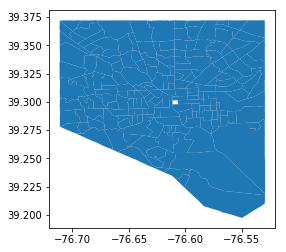

In [27]:
for thisyear in [2016, 2017]:
    print('selecting {0:.0f}...'.format(thisyear))
    #agg_tracts_gdf = agg_tracts_gdf.set_index(['census_tract', 'activity_year'])
    xdf = agg_tracts_df[agg_tracts_df['activity_year'] == thisyear]
    xdf = xdf.set_index('census_tract')

    print('reading ACS5 data...')
    metadata_df = pandas.read_csv(census_data_dir+'acs5_metadata_md_2017.csv', encoding='utf-8', index_col='varnum')
    metadata_df = metadata_df.sort_index()
    #metadata_df.sample(3)
    acs5_x_df = pandas.read_csv(census_data_dir+'acs5_md_2017.csv', encoding='utf-8')#, index_col='GEOID')
    print('keeping only Baltimore City census tracts...')
    acs5_x_df = acs5_x_df[acs5_x_df['GEOID'].apply(lambda x: '14000US24510' in x)]

    print('joining census data...')
    acs5_x_df = acs5_x_df.assign(census_tract = pandas.to_numeric(acs5_x_df['GEOID'].apply(lambda x: x[12:16]+'.'+x[16:]), errors='coerce'))
    xdf = xdf.reset_index().merge(acs5_x_df, how='left', on='census_tract').set_index('census_tract')

    # add shapefiles
    print('joining shapefiles...')
    
    
    
    tract_shapes_gdf = geopandas.read_file(tiger_basedir +'{0:.0f}/TRACT/tl_{0:.0f}_24_tract.shp'.format(thisyear))
    tract_shapes_gdf = tract_shapes_gdf[tract_shapes_gdf['COUNTYFP'] == '510']
    tract_shapes_gdf.loc[:, 'NAME'] = pandas.to_numeric(tract_shapes_gdf['NAME'], errors='coerce')
    tract_shapes_gdf = tract_shapes_gdf.assign(census_tract = pandas.to_numeric(tract_shapes_gdf['GEOID'].apply(lambda x: x[5:9]+'.'+x[9:]), errors='coerce'))
    xgdf = geopandas.GeoDataFrame(xdf.reset_index().merge(tract_shapes_gdf, how='left', on='census_tract').set_index('census_tract'), crs=tract_shapes_gdf.crs, geometry='geometry')
    print('Done!')
xgdf.plot()


# Add shapefiles for 2016 or 2017

backing up...


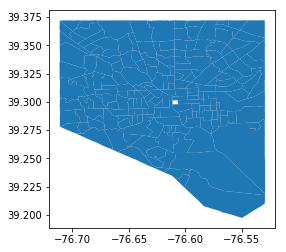

In [24]:

#tract_shapes_gdf = tract_shapes_gdf.set_index('tractnum')

#agg_tracts_gdf[agg_tracts_gdf.index.get_level_values('activity_year') == 2016].plot(column='nLoans1')
#plt.show()
#agg_tracts_gdf['census_tract'][(agg_tracts_gdf['activity_year'] == 2016)].drop_duplicates()#[:40] #& (agg_tracts_gdf['census_tract'].apply(lambda x: int(str(x)[0]) > 2))]
#--101.00, 201.00 801.01, 801.02, 1001.00, 1308.03, 2001.00, 2101.00, 2501.01, 2606.01, 2701.01, 2801.01

#print('backing up...')
#agg_tracts_2015_gdf_bk = agg_tracts_2015_gdf

#print('Done')
#agg_tracts_2015_gdf.geometry
#agg_tracts_2017_df#.merge(tract_shapes_gdf, how='left', on='tractnum')
#agg_tracts_2017_df.join(tract_shapes_gdf)


print('backing up...')

agg_tracts_2017_gdf.plot()

#tract_shapes_gdf.geometry



## Add working loans column (ask Mac)

In [ ]:
print('getting from backup...')
agg_tracts_2017_df = agg_tracts_2015_gdf_bk


agg_tracts_2015_gdf = agg_tracts_2015_gdf.assign(avgSmallLoan = (agg_tracts_2015_gdf['amtLoans1'] / agg_tracts_2015_gdf['nLoans1']))

agg_tracts_2015_gdf = agg_tracts_2015_gdf.assign(nWorkingLoans = agg_tracts_2015_gdf['nLoansTotal'][agg_tracts_2015_gdf['avgSmallLoan'] < 10000] - agg_tracts_2015_gdf['nLoans1'][agg_tracts_2015_gdf['avgSmallLoan'] < 10000])
agg_tracts_2015_gdf = agg_tracts_2015_gdf.assign(amtWorkingLoans = agg_tracts_2015_gdf['amtLoansTotal'][agg_tracts_2015_gdf['avgSmallLoan'] < 10000] - agg_tracts_2015_gdf['amtLoans1'][agg_tracts_2015_gdf['avgSmallLoan'] < 10000])

#agg_tracts_2015_gdf['amtWorkingLoans']
        


agg_tracts_2015_gdf.loc[agg_tracts_2015_gdf['avgSmallLoan'] >= 10000, 'nWorkingLoans'] = agg_tracts_2015_gdf['nLoansTotal'][agg_tracts_2015_gdf['avgSmallLoan'] >= 10000]
agg_tracts_2015_gdf.loc[agg_tracts_2015_gdf['avgSmallLoan'] >= 10000, 'amtWorkingLoans'] = agg_tracts_2015_gdf['amtLoansTotal'][agg_tracts_2015_gdf['avgSmallLoan'] >= 10000]


print('backing up...')
agg_tracts_2015_gdf_bk = agg_tracts_2015_gdf

print('Done')


# Figure out which tracts will require special casing below

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_aspect('equal')
agg_tracts_2015_gdf[
    (agg_tracts_2015_gdf.index <= 1201)    # Part a
    #((agg_tracts_2015_gdf.index == 1202.01) | (agg_tracts_2015_gdf.index == 1202.02))   # Part b
    #(agg_tracts_2015_gdf.index >= 1203) & (agg_tracts_2015_gdf.index < 1308)   # Part c
    #(agg_tracts_2015_gdf.index >= 1308) & (agg_tracts_2015_gdf.index < 1400)   # Part d
    #(agg_tracts_2015_gdf.index >= 1400) & (agg_tracts_2015_gdf.index < 1507)   # Part e
    #(agg_tracts_2015_gdf.index >= 1507) & (agg_tracts_2015_gdf.index < 1508)   # Part f
    #(agg_tracts_2015_gdf.index >= 1508) & (agg_tracts_2015_gdf.index < 1608)   # Part g
    #(agg_tracts_2015_gdf.index >= 1608) & (agg_tracts_2015_gdf.index < 1700)   # Part h
    #(agg_tracts_2015_gdf.index >= 1700) & (agg_tracts_2015_gdf.index < 2007)   # Part i
    #(agg_tracts_2015_gdf.index >= 2007) & (agg_tracts_2015_gdf.index < 2008)   # Part j
    #(agg_tracts_2015_gdf.index >= 2008) & (agg_tracts_2015_gdf.index < 2500)   # Part k
    #(agg_tracts_2015_gdf.index >= 2806) & (agg_tracts_2015_gdf.index < 2810)   # Part l
].plot(ax=ax, color='white', edgecolor='black')

for ix, thisrow in agg_tracts_2015_gdf[
    (agg_tracts_2015_gdf.index <= 1201)    # Part a
    #((agg_tracts_2015_gdf.index == 1202.01) | (agg_tracts_2015_gdf.index == 1202.02))   # Part b
    #(agg_tracts_2015_gdf.index >= 1203) & (agg_tracts_2015_gdf.index < 1308)   # Part c
    #(agg_tracts_2015_gdf.index >= 1308) & (agg_tracts_2015_gdf.index < 1400)    # Part d
    #(agg_tracts_2015_gdf.index >= 1400) & (agg_tracts_2015_gdf.index < 1507)   # Part e
    #(agg_tracts_2015_gdf.index >= 1507) & (agg_tracts_2015_gdf.index < 1508)   # Part f
    #(agg_tracts_2015_gdf.index >= 1508) & (agg_tracts_2015_gdf.index < 1608)   # Part g
    #(agg_tracts_2015_gdf.index >= 1608) & (agg_tracts_2015_gdf.index < 1700)   # Part h
    #(agg_tracts_2015_gdf.index >= 1700) & (agg_tracts_2015_gdf.index < 2007)   # Part i
    #(agg_tracts_2015_gdf.index >= 2007) & (agg_tracts_2015_gdf.index < 2008)   # Part j
    #(agg_tracts_2015_gdf.index >= 2008) & (agg_tracts_2015_gdf.index < 2500)   # Part k
    #(agg_tracts_2015_gdf.index >= 2806) & (agg_tracts_2015_gdf.index < 2810)   # Part l
].iterrows():
    annotator = str(ix)
    annotator = annotator.replace('/','/\n')
    ax.annotate(annotator, 
                xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                ha='center', va='center', backgroundcolor='white', fontsize=9)
plt.show()
#agg_tracts_2015_gdf.index.values

# Add number of jobs per census tract

## Find number of jobs per census tract

Takes a lot of finagling.

In [ ]:
print('getting from backup...')
agg_tracts_2015_gdf = agg_tracts_2015_gdf_bk

print('reading job data...')
#agg_tracts_2016_acs5_2017.to
raw_jobs_df = pandas.read_csv(datadir+'md_wac_S000_JT02_2010_to_2015.csv')
raw_jobs_df.columns = [x.strip() for x in raw_jobs_df.columns.tolist()]

# GeoID format is STATE+COUNTY+TRACT+BLOCK (2+3+6+4 = 15 characters)
raw_jobs_df = raw_jobs_df.assign(
    census_tract = pandas.to_numeric(
            (
            raw_jobs_df['Workplace Census Block Code'].apply(lambda x: str(x)[5:9]) + '.' + 
            raw_jobs_df['Workplace Census Block Code'].apply(lambda x: str(x)[10:12])
            ).astype('str')
            , errors='coerce'
        )
)
#sum_columns = [x in 
sum_columns = [x for x in raw_jobs_df.columns.tolist() if x not in ('Workplace Census Block Code', 'Year')]

jobs_2015_df = raw_jobs_df[sum_columns][raw_jobs_df['Year'] == 2015].groupby('census_tract', as_index=False).sum()

special_cases = [801, 803, 1202, 1308, 1507, 1608, 2007, 2501, 2502, 2503, 2504, 2601]
special_cases += [2602, 2603, 2604, 2605, 2606, 2701, 2703, 2704, 2705, 2707, 2708]
special_cases += [2709, 2710, 2711, 2715, 2718, 2720, 2801, 2803, 2804]

jobs_2015_df = jobs_2015_df.assign(census_tract_big = np.nan)

for x in special_cases:
    jobs_2015_df.loc[
        (jobs_2015_df['census_tract'] >= x) & (jobs_2015_df['census_tract'] < x+1)
        , 'census_tract_big'] = pandas.to_numeric(
        jobs_2015_df['census_tract'][
        (jobs_2015_df['census_tract'] >= x) & (jobs_2015_df['census_tract'] < x+1)
    ].apply(lambda x: str(x)[0:str(x).find('.')]+'.0'+str(x)[str(x).find('.')+1:-1])
        , errors='coerce')
    
special_case_tract_list = jobs_2015_df['census_tract_big'].dropna().drop_duplicates().tolist()

sum_columns = [x for x in sum_columns if x != 'census_tract']

joiner_2015_special_case_df = jobs_2015_df[jobs_2015_df['census_tract_big'].isin(special_case_tract_list)].groupby('census_tract_big')[sum_columns].sum()



jobs_2015_df.loc[jobs_2015_df['census_tract_big'].isnull(), 'census_tract_big'] = pandas.to_numeric(jobs_2015_df['census_tract'][jobs_2015_df['census_tract_big'].isnull()].apply(lambda x: np.floor(x)), errors='coerce')

joiner_2015_df = jobs_2015_df[~jobs_2015_df['census_tract_big'].isin(special_case_tract_list)].groupby('census_tract_big')[sum_columns].sum()

joiner_2015_df = pandas.concat((joiner_2015_df, joiner_2015_special_case_df), axis=0)
joiner_2015_df = joiner_2015_df.sort_index()


agg_tracts_2015_gdf = agg_tracts_2015_gdf.join(joiner_2015_df, how='left')

print('backing up...')
agg_tracts_2015_gdf_bk = agg_tracts_2015_gdf

print('ok')

## Calculate number of loans per job in each census tract

In [ ]:
print('getting from backup...')
agg_tracts_2015_gdf = agg_tracts_2015_gdf_bk

#'Total number of jobs'

loan_columns = ['nLoans1', 'amtLoans1', 'nLoans100k', 'amtLoans100k']
loan_columns += ['nLoans250k', 'amtLoans250k', 'nLoansToSmallest', 'amtLoansToSmallest']
loan_columns += ['nLoansTotal', 'amtLoansTotal']

agg_tracts_2015_gdf = agg_tracts_2015_gdf.assign(
    nLoans1_per_job = agg_tracts_2015_gdf['nLoans1'] / agg_tracts_2015_gdf['Total number of jobs']
)
agg_tracts_2015_gdf = agg_tracts_2015_gdf.assign(
    amtLoans1_per_job = agg_tracts_2015_gdf['amtLoans1'] / agg_tracts_2015_gdf['Total number of jobs']
)
agg_tracts_2015_gdf = agg_tracts_2015_gdf.assign(
    nLoans100k_per_job = agg_tracts_2015_gdf['nLoans100k'] / agg_tracts_2015_gdf['Total number of jobs']
)
agg_tracts_2015_gdf = agg_tracts_2015_gdf.assign(
    amtLoans100k_per_job = agg_tracts_2015_gdf['amtLoans100k'] / agg_tracts_2015_gdf['Total number of jobs']
)
agg_tracts_2015_gdf = agg_tracts_2015_gdf.assign(
    nLoans250k_per_job = agg_tracts_2015_gdf['nLoans250k'] / agg_tracts_2015_gdf['Total number of jobs']
)
agg_tracts_2015_gdf = agg_tracts_2015_gdf.assign(
    amtLoans250k_per_job = agg_tracts_2015_gdf['amtLoans250k'] / agg_tracts_2015_gdf['Total number of jobs']
)
agg_tracts_2015_gdf = agg_tracts_2015_gdf.assign(
    nLoansToSmallest_per_job = agg_tracts_2015_gdf['nLoansToSmallest'] / agg_tracts_2015_gdf['Total number of jobs']
)
agg_tracts_2015_gdf = agg_tracts_2015_gdf.assign(
    amtLoansToSmallest_per_job = agg_tracts_2015_gdf['amtLoansToSmallest'] / agg_tracts_2015_gdf['Total number of jobs']
)
agg_tracts_2015_gdf = agg_tracts_2015_gdf.assign(
    nLoansTotal_per_job = agg_tracts_2015_gdf['nLoansTotal'] / agg_tracts_2015_gdf['Total number of jobs']
)
agg_tracts_2015_gdf = agg_tracts_2015_gdf.assign(
    amtLoansTotal_per_job = agg_tracts_2015_gdf['amtLoansTotal'] / agg_tracts_2015_gdf['Total number of jobs']
)

agg_tracts_2015_gdf = agg_tracts_2015_gdf.assign(
    nLoansTotal_per_job = agg_tracts_2015_gdf['nWorkingLoans'] / agg_tracts_2015_gdf['Total number of jobs']
)
agg_tracts_2015_gdf = agg_tracts_2015_gdf.assign(
    amtLoansTotal_per_job = agg_tracts_2015_gdf['amtWorkingLoans'] / agg_tracts_2015_gdf['Total number of jobs']
)

print('backing up...')
agg_tracts_2015_gdf_bk = agg_tracts_2015_gdf

print('Done')


#agg_tracts_2015_gdf
#agg_tracts_2015_gdf[loan_columns].columns.tolist()
    

#df
#agg_tracts_2015_gdf.columns

In [ ]:
print('getting from backup...')
agg_tracts_2015_gdf = agg_tracts_2015_gdf_bk

agg_tracts_2015_gdf = agg_tracts_2015_gdf.assign(
    nWorkingLoans_per_job = agg_tracts_2015_gdf['nWorkingLoans'] / 
    agg_tracts_2015_gdf['Total number of jobs'])

agg_tracts_2015_gdf = agg_tracts_2015_gdf.assign(
    amtWorkingLoans_per_job = agg_tracts_2015_gdf['amtWorkingLoans'] / 
    agg_tracts_2015_gdf['Total number of jobs'])


agg_tracts_2015_gdf = agg_tracts_2015_gdf.assign(
    nWorkingLoans_per_white_job = agg_tracts_2015_gdf['nWorkingLoans'] / 
    agg_tracts_2015_gdf['Number of jobs for workers with Race: White, Alone'])
agg_tracts_2015_gdf = agg_tracts_2015_gdf.assign(
    amtWorkingLoans_per_white_job = agg_tracts_2015_gdf['amtWorkingLoans'] / 
    agg_tracts_2015_gdf['Number of jobs for workers with Race: White, Alone'])

agg_tracts_2015_gdf = agg_tracts_2015_gdf.assign(
    nWorkingLoans_per_black_job = agg_tracts_2015_gdf['nWorkingLoans'] / 
    agg_tracts_2015_gdf['Number of jobs for workers with Race: Black or African American Alone'])
agg_tracts_2015_gdf = agg_tracts_2015_gdf.assign(
    amtWorkingLoans_per_black_job = agg_tracts_2015_gdf['amtWorkingLoans'] / 
    agg_tracts_2015_gdf['Number of jobs for workers with Race: Black or African American Alone'])

print('backing up...')
agg_tracts_2015_gdf_bk = agg_tracts_2015_gdf

#print('Done')
#agg_tracts_2015_gdf.columns
print('Done')

# Add ACS 5-year estimates from 2017

In [ ]:
print('getting from backup...')
agg_tracts_2015_gdf = agg_tracts_2015_gdf_bk

print('getting ACS 5-year estimates for 2012-2017...')
acs5_2017_df = pandas.read_csv(datadir+'acs5/cra_iv_estimates.csv', low_memory=False, index_col='tract')
acs5_2017_df.index.name = 'census_tract'

print('Getting these columns...')
acs5_2017_df.columns.tolist()

for x in acs5_2017_df.columns.tolist():
    acs5_2017_df.loc[:, x] = pandas.to_numeric(acs5_2017_df[x], errors='coerce')

acs5_2017_df

In [ ]:

agg_tracts_2015_gdf = agg_tracts_2015_gdf.join(acs5_2017_df, how='left')

print('backing up...')
agg_tracts_2015_gdf_bk = agg_tracts_2015_gdf

print('Done!')

In [ ]:
print('getting from backup...')
agg_tracts_2015_gdf = agg_tracts_2015_gdf_bk
print('\n')
print('writing outfiles...')
neworder = [x for x in agg_tracts_2015_gdf.columns.tolist() if x != 'geometry']


agg_tracts_2015_gdf[neworder].to_csv(datadir+'cra_data_final_for_mac_2015.csv', encoding='utf-8')
agg_tracts_2015_gdf.to_file('cra_data_final_for_mac_2015.shp')

neworder.append('geometry')
agg_tracts_2015_gdf[neworder].reset_index().to_file(datadir+'cra_data_final_for_mac_2015.shp')  # need to do a reset_index() so index gets written too

with open(datadir+'column_names.csv', 'w') as f:
    for x in agg_tracts_2015_gdf[neworder].reset_index().columns.tolist():  # need to do a reset_index() so index gets written too
        if (x.find(",") > -1):
            x = x.replace(",","\,'")
        f.write(x)
        if (x not in agg_tracts_2015_gdf[neworder].reset_index().columns.tolist()[-1:]):
            f.write(', ')
print('Done!')


In [ ]:

# Unit of analysis: census tract
# DV: nLoans1, amtLoans1, etc. Also: (overall minus "credit card loans")
#### where credit card loans" are <$100k to businesses with <$10k budget
# IV: [population by race; owner-occupied units; MFI; hs grad pct; 
### female hoh pct; unemployment pct; poverty pct; median home value;
### median home year built